https://datascience.stackexchange.com/questions/32480/how-does-generalised-advantage-estimation-work
https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html#combining-td-and-mc-learning
https://arxiv.org/pdf/1506.02438.pdf
https://github.com/higgsfield/RL-Adventure-2
http://www.breloff.com/DeepRL-OnlineGAE/
https://arxiv.org/pdf/1804.02717.pdf
https://ewrl.files.wordpress.com/2015/02/ewrl12_2015_submission_18.pdf
https://github.com/Kaixhin/Dist-A3C
https://github.com/Kaixhin/Dist-A3C/blob/master/client.py

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import gym

In [2]:
env = gym.make('CartPole-v1')

assert isinstance(env.observation_space, gym.spaces.Box)
assert isinstance(env.action_space, gym.spaces.Discrete)

In [3]:
SEED = 1234

env.seed(SEED);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.25):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [5]:
INPUT_DIM = env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)
        
actor.apply(init_weights)
critic.apply(init_weights)

MLP(
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.25)
)

In [7]:
LEARNING_RATE = 0.01

actor_optimizer = optim.Adam(actor.parameters(), lr = LEARNING_RATE)
critic_optimizer = optim.Adam(critic.parameters(), lr = LEARNING_RATE)

In [8]:
def train(env, actor, critic, actor_optimizer, critic_optimizer, discount_factor, trace_decay):
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        action_preds = actor(state)
        value_pred = critic(state)
                
        action_probs = F.softmax(action_preds, dim = -1)
                
        dist = distributions.Categorical(action_probs)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward
    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    advantages = calculate_advantages(rewards, values, discount_factor, trace_decay)
    
    policy_loss, value_loss = update_policy(advantages, log_prob_actions, values, actor_optimizer, critic_optimizer)

    return policy_loss, value_loss, episode_reward

In [9]:
def calculate_advantages(rewards, values, discount_factor, trace_decay, normalize = True):
    
    advantages = []
    advantage = 0
    next_value = 0
    
    for r, v in zip(reversed(rewards), reversed(values)):
        td_error = r + next_value * discount_factor - v
        advantage = td_error + advantage * discount_factor * trace_decay
        next_value = v
        advantages.insert(0, advantage)
        
    advantages = torch.tensor(advantages)
    
    if normalize:
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [10]:
def update_policy(advantages, log_prob_actions, values, actor_optimizer, critic_optimizer):
        
    advantages = advantages.detach()
        
    policy_loss = - (advantages * log_prob_actions).mean()
    
    value_loss = F.smooth_l1_loss(advantages, values).mean()
        
    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()
    
    policy_loss.backward()
    value_loss.backward()
    
    actor_optimizer.step()
    critic_optimizer.step()
    
    return policy_loss.item(), value_loss.item()

In [11]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
TRACE_DECAY = 0.95
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

episode_rewards = []

for episode in tqdm(range(1, MAX_EPISODES+1)):
    
    policy_loss, value_loss, episode_reward = train(env, actor, critic, actor_optimizer, critic_optimizer, DISCOUNT_FACTOR, TRACE_DECAY)
    
    episode_rewards.append(episode_reward)
    
    mean_trial_rewards = np.mean(episode_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:4} | Mean Rewards: {mean_trial_rewards:6.2f} |')
    
    if mean_trial_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:   10 | Mean Rewards:  22.80 |
| Episode:   20 | Mean Rewards:  29.70 |
| Episode:   30 | Mean Rewards:  31.52 |
| Episode:   40 | Mean Rewards:  45.44 |
| Episode:   50 | Mean Rewards:  55.68 |
| Episode:   60 | Mean Rewards: 134.48 |
| Episode:   70 | Mean Rewards: 194.60 |
| Episode:   80 | Mean Rewards: 275.24 |
| Episode:   90 | Mean Rewards: 360.88 |
| Episode:  100 | Mean Rewards: 348.00 |
| Episode:  110 | Mean Rewards: 210.36 |
| Episode:  120 | Mean Rewards: 138.44 |
| Episode:  130 | Mean Rewards: 120.36 |
| Episode:  140 | Mean Rewards: 254.60 |
| Episode:  150 | Mean Rewards: 398.92 |
Reached reward threshold in 156 episodes


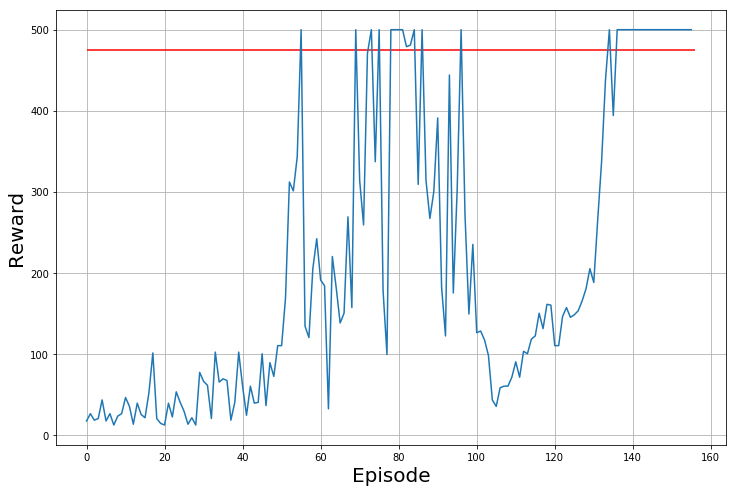

In [12]:
plt.figure(figsize=(12,8))
plt.plot(episode_rewards)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(episode_rewards), color='r')
plt.grid()